In [4]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import copy

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, PCA
from sklearn.manifold import TSNE, MDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [5]:
df = pd.read_csv('../hurwitzlab/data_sets/HMP_V13_OTU_counts.csv')
df = df.drop(columns = ['PSN'])
body_sites = pd.read_csv('../hurwitzlab/data_sets/HMP_V13_participant_data.csv')

In [6]:
df['body_sites'] = body_sites['HMP_BODY_SITE']

df = df[df['body_sites'] == 'Oral']

df = df.drop(columns=['body_sites'])

body_sites = body_sites[body_sites['HMP_BODY_SITE'] == 'Oral']

In [8]:
body_site_mapping = {site: idx for idx, site in enumerate(body_sites['HMP_BODY_SUBSITE'].unique())}

body_site_ints = body_sites['HMP_BODY_SUBSITE'].map(body_site_mapping)

In [9]:
# Standardize the data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

# Initial dimensionality reduction
pca = PCA(n_components=50)
reduced_df = pca.fit_transform(scaled_df)

# Dimensionality reduction for visualization
tsne = TSNE(n_components=2, init='pca', random_state=0)
result = tsne.fit_transform(reduced_df)

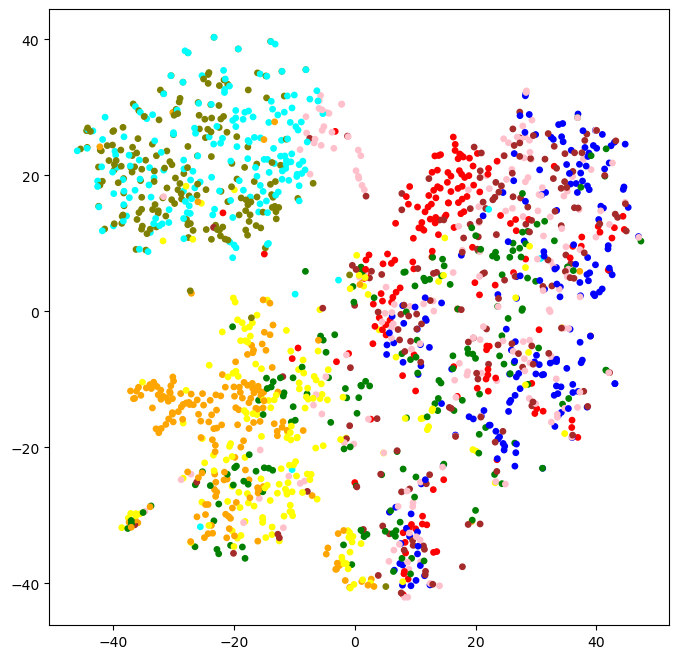

In [10]:
custom_colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'brown', 'olive', 'cyan']
cmap = ListedColormap(custom_colors)

# Plot with body sites
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
scatter = plt.scatter(result[:, 0], result[:, 1], c=body_site_ints, cmap=cmap, s=15)
plt.savefig("body_site_plot.svg")
plt.show()

In [11]:
threshold = 5
#df[df < threshold] = 0

df = df.loc[:, (df != 0).sum(axis=0) > threshold]

#remove taxa that occur less than a certain number of times across all samples (prevalence)
#try things on mouth
#try scikit clustering methods (hierarchical and k-means clustering)

frequency_table = df.values

bestLDA = LatentDirichletAllocation(n_components=5, random_state=0)
bestLDA.fit(frequency_table)
lowestPerplexity = bestLDA.perplexity(frequency_table)
componentNum = 5
print(componentNum, ',', lowestPerplexity, '\n')
componentNum += 1


decreasing = 1

while decreasing == 1:
    LDA = LatentDirichletAllocation(n_components=componentNum, random_state=0)
    LDA.fit(frequency_table)
    perplexity = LDA.perplexity(frequency_table)

    print(componentNum, ', ', perplexity, '\n')
    
    if perplexity < lowestPerplexity:
        bestLDA = copy.deepcopy(LDA)
        lowestPerplexity = perplexity
    else:
        decreasing = 0
    componentNum += 1

print('Mouth - Component number:', componentNum, ', Perplexity:', perplexity, '\n')


5 , 1110.7707122774918 

6 ,  1034.4644237508974 

7 ,  1012.5676998549262 

8 ,  994.2383403847189 

9 ,  960.7467855781522 

10 ,  940.0943863302269 

11 ,  918.2639983040073 

12 ,  892.3683897511976 

13 ,  900.6700893764989 

Mouth - Component number: 14 , Perplexity: 900.6700893764989 



In [13]:
frequency_table = df.values
topic_distributions = bestLDA.transform(frequency_table)

strongest_topic_indices = topic_distributions.argmax(axis=1)

body_sites['Strongest_Topic'] = strongest_topic_indices

topic_counts_by_site = body_sites.groupby(['HMP_BODY_SUBSITE', 'Strongest_Topic']).size().unstack(fill_value=0)

print(topic_counts_by_site)

Strongest_Topic               0   1   2   3    4   5   6   7   8   9   10  11
HMP_BODY_SUBSITE                                                             
Attached Keratinized Gingiva   0   2   0   0    4  17   0   3   2  76   6  71
Buccal Mucosa                  0   1  11   1   10  47   2  22   0  74   8   7
Hard Palate                    2   1  49   6    0  33   2   2   0  33  49   1
Palatine Tonsils               7   0  60  35    2   5   0   5  23   6  42   1
Saliva                         3   2  49  71    3   1   1   1   2   3  25   1
Subgingival Plaque             0  21   0   1   82   1   6   1  69   1   1   0
Supragingival Plaque           0  30   0   0  131   0   7   0  19   2   0   0
Throat                         8   1  48  60    0   4   3   6   2   5  32   1
Tongue Dorsum                  4   0  81  38    0   0   0   0   0   0  67   0
